# Overview
In this book, I build a person vs robot detector based on hand-built custom dataset using both Yolov5 and the Detectron2 implementation of Faster RCNN.

# YOLO5

## Installing Dependencies

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies

%cd /content/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15598, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 15598 (delta 97), reused 119 (delta 56), pack-reused 15393
Receiving objects: 100% (15598/15598), 14.58 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (10626/10626), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 920.5 kB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation:

In [ ]:
import torch
from IPython.display import Image  # for displaying images
# from utils.google_utils import gdrive_download

# check which gpu is provided by google
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


torch 2.0.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
! pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=b80c49574bcf17b44127ed4c01a07732a48ff29f3868b285b738a66073d02260
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

## Downloading the dataset

In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="AVTlVhzQ74j8nTZMUzWk")
project = rf.workspace("innopolis-university-mt8jm").project("innopolis-detector-segmentation")
dataset = project.version(3).download("yolov5")

version_num = dataset.version

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to innopolis-detector-segmentation-3 in yolov5pytorch:: 100%|██████████| 538/538 [00:00<00:00, 599.92it/s]


## Visualizing samples of the dataset
Before Delving into building models, let's take a look on the dataset. Here is a random sample of the original images

In [ ]:
import os
import numpy as np
import cv2
import random
random.seed(69)
from google.colab.patches import cv2_imshow


def plot_images(imgs_paths, new_size=None):
  # iteratte through all images
  for path in imgs_paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # if the new_size parameter is set, then change the size of the image 
    # and display it
    if new_size is not None:
      img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    cv2_imshow(img)

current directory: /content/yolov5


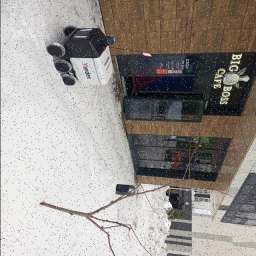

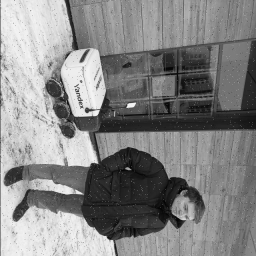

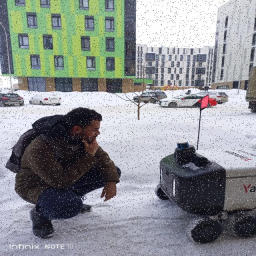

In [ ]:
# let's see a sample of the training dataset

random.seed(69)
print(f"current directory: {os.getcwd()}")
data_location = os.path.join(f'innopolis-detector-segmentation-{version_num}')
train_images_loc = os.path.join(data_location, 'train', 'images')

# let's set the full paths of the images
train_images_paths = [os.path.join(train_images_loc, file_name) for file_name in os.listdir(train_images_loc)]

random_images = random.sample(train_images_paths, k=3)

plot_images(random_images, new_size=(256, 256))

As I found no ready-to-use functionalities to display the ground-truth bounding boxes, I had to write my own.

In [ ]:
import random
random.seed(11)

def read_image_label_yolo5(text_path):
  """
  This function extracts the bounding box parameters according to the Yolov5 format. Please refer to the following link:
  https://roboflow.com/formats/yolov5-pytorch-txt
  """
  with open(text_path, 'r') as f: 
    splits = [l[:-1].split() for l in f.readlines()]
    # ipdb.set_trace(context=6)
    boxes = [{"class": int(s[0]), "x": float(s[1]), "y": float(s[2]), "width": float(s[3]), "height": float(s[4])} for s in splits]
    # ipdb.set_trace(context=6)

  return boxes


def visualize_bounding_boxes(initial_image, bounding_boxes: dict):
  """
  initial_image: Image object read by cv2
  
  bounding_boxes: an iterable of dictionary object where each dictionary 
  is assumed to have the same elements as the ones generated by read_image_label_yolo5

  """
  image_shape = np.asarray(initial_image).shape
  print(image_shape)
  for b in bounding_boxes:
    # denormalize the values by multiplying the values by the corresponding
    # images' dimensions

    center_x = b['x'] * image_shape[0]
    center_y = b['y'] * image_shape[1]
    width = b['width'] * image_shape[0] 
    height = b['height'] * image_shape[1]

    x0 = center_x - width / 2
    x1 = center_x + width / 2
    
    y0 = center_y - height / 2
    y1 = center_y + height / 2

    # add a breakpoint
    # ipdb.set_trace(context=6)
    start_point = start_point = (int(x0), int(y0))
    end_point = (int(x1), int(y1))
    # the color of the box should depend on the class of the object
    box_color = (0, 255, 0) if b['class'] == 0 else (255, 0, 0)
    cv2.rectangle(initial_image, start_point, end_point, color=box_color, thickness=2)
  
  cv2_imshow(initial_image)


def plot_bounding_boxes(roboflow_directory: str, n_samples: int):
  """Given the directory, create visualize the bounding boxes of a random set of images"""
  # the directory is assumed to follow the roboflow dataset architecture
  images_dir = os.path.join(roboflow_directory, 'images') # directory for images
  labels_dir = os.path.join(roboflow_directory, 'labels') # directory for labels
  # ipdb.set_trace(context=6)

  images_and_labels = list(zip(sorted(os.listdir(images_dir)), sorted(os.listdir(labels_dir))))
  # ipdb.set_trace(context=6)

  # take a random sample of the created list
  random_sample = random.sample(images_and_labels, k=n_samples)
  
  for img_name, label_file in random_sample: 
    # extract the dictionary with the exact coordinates
    boxes = read_image_label_yolo5(os.path.join(labels_dir, label_file))
    # read the image using cv2
    img = cv2.imread(os.path.join(images_dir, img_name))
    visualize_bounding_boxes(img, boxes)



## Train Yolo5

In [ ]:
# define a file-management variable for further use
import os
HOME = r'/content'
print(HOME)


/content


In [ ]:
%cd {HOME}/yolov5 
!python segment/train.py --img 640 --batch 32 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5n-seg.pt --name custom-dataset


/content/yolov5
segment/train: weights=yolov5n-seg.pt, cfg=, data=/content/yolov5/innopolis-detector-segmentation-3/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train-seg, name=custom-dataset, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, mask_ratio=4, no_overlap=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-155-g8ecc727 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls

In [ ]:
# let's take a look on the training results
! ls {HOME}/yolov5/runs/train-seg/custom-dataset


BoxF1_curve.png					    MaskPR_curve.png
BoxP_curve.png					    MaskR_curve.png
BoxPR_curve.png					    opt.yaml
BoxR_curve.png					    results.csv
confusion_matrix.png				    results.png
events.out.tfevents.1682759769.d595c0dbc109.1084.0  train_batch0.jpg
hyp.yaml					    train_batch1.jpg
labels_correlogram.jpg				    train_batch2.jpg
labels.jpg					    val_batch0_labels.jpg
MaskF1_curve.png				    val_batch0_pred.jpg
MaskP_curve.png					    weights


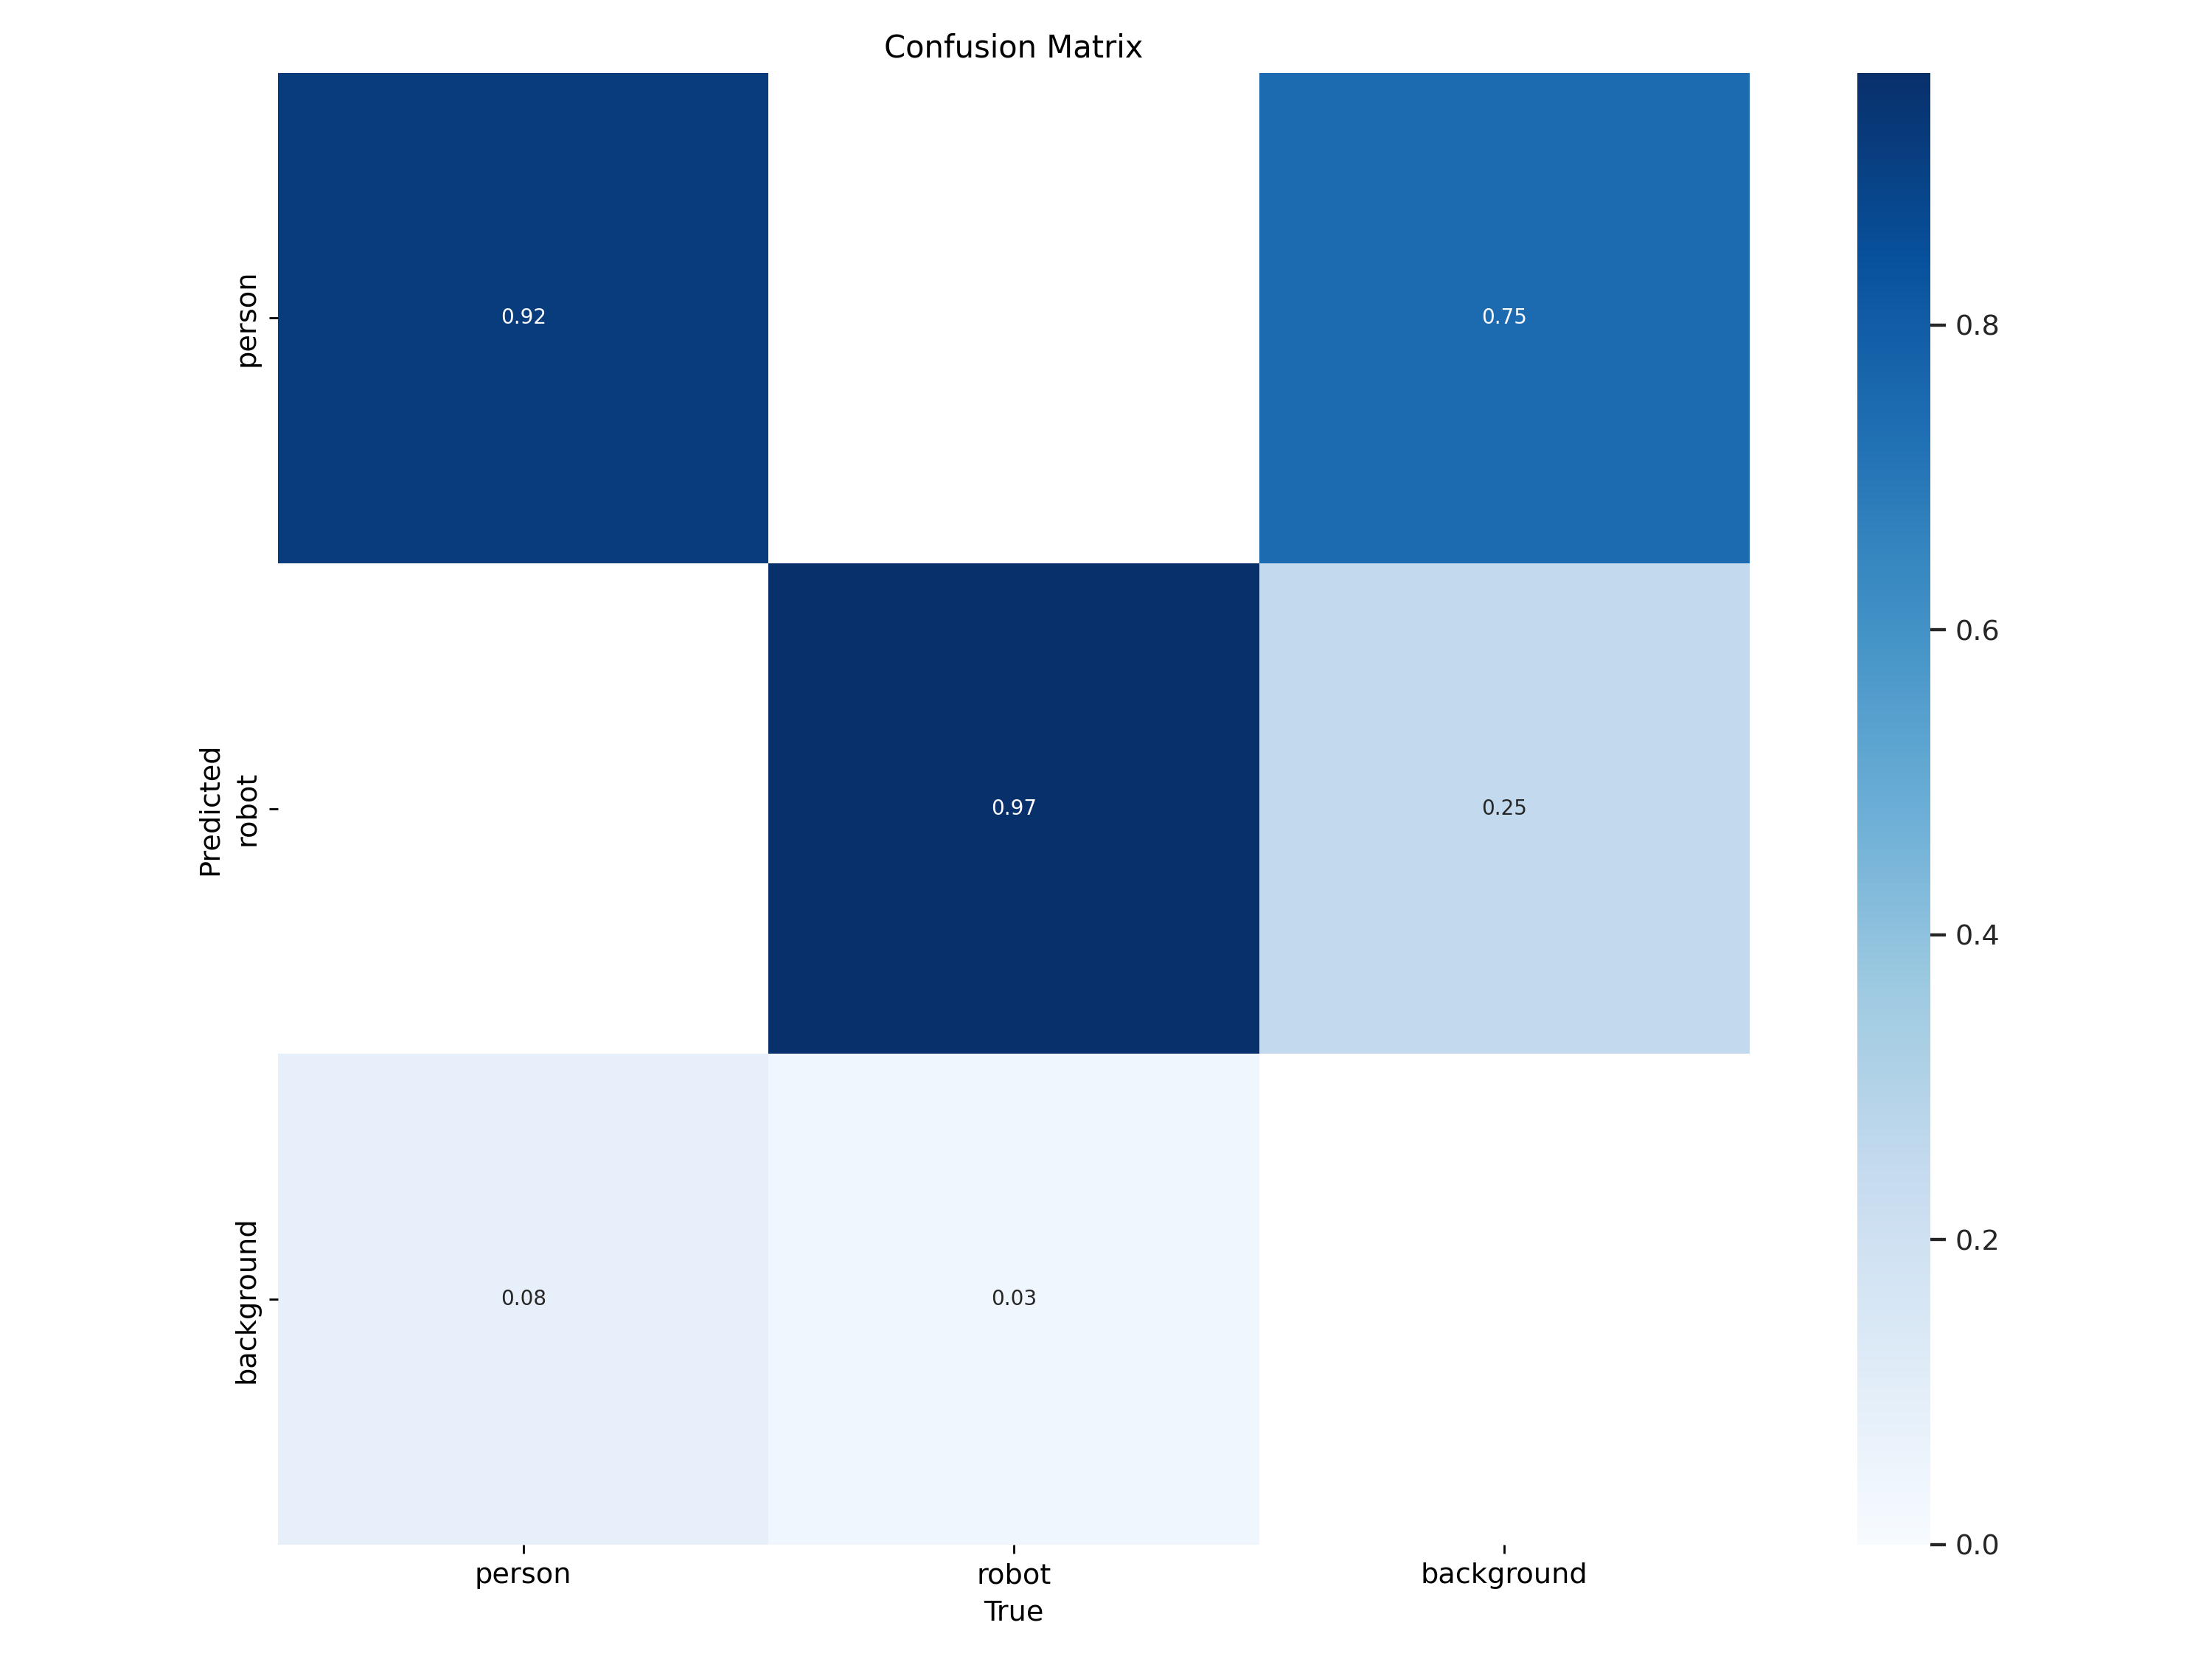

In [ ]:
# let's display the confusion matrix
Image(filename=f'{HOME}/yolov5/runs/train-seg/custom-dataset/confusion_matrix.png', width=600)

*  The model differentiates well between the **PERSON** and **ROBOT** classes as it does not predict one as the other.
* The recall on the other hand might be alarming specially with the **PERSON** class. One possible solution is to increase the occurrence of that class in our dataset.

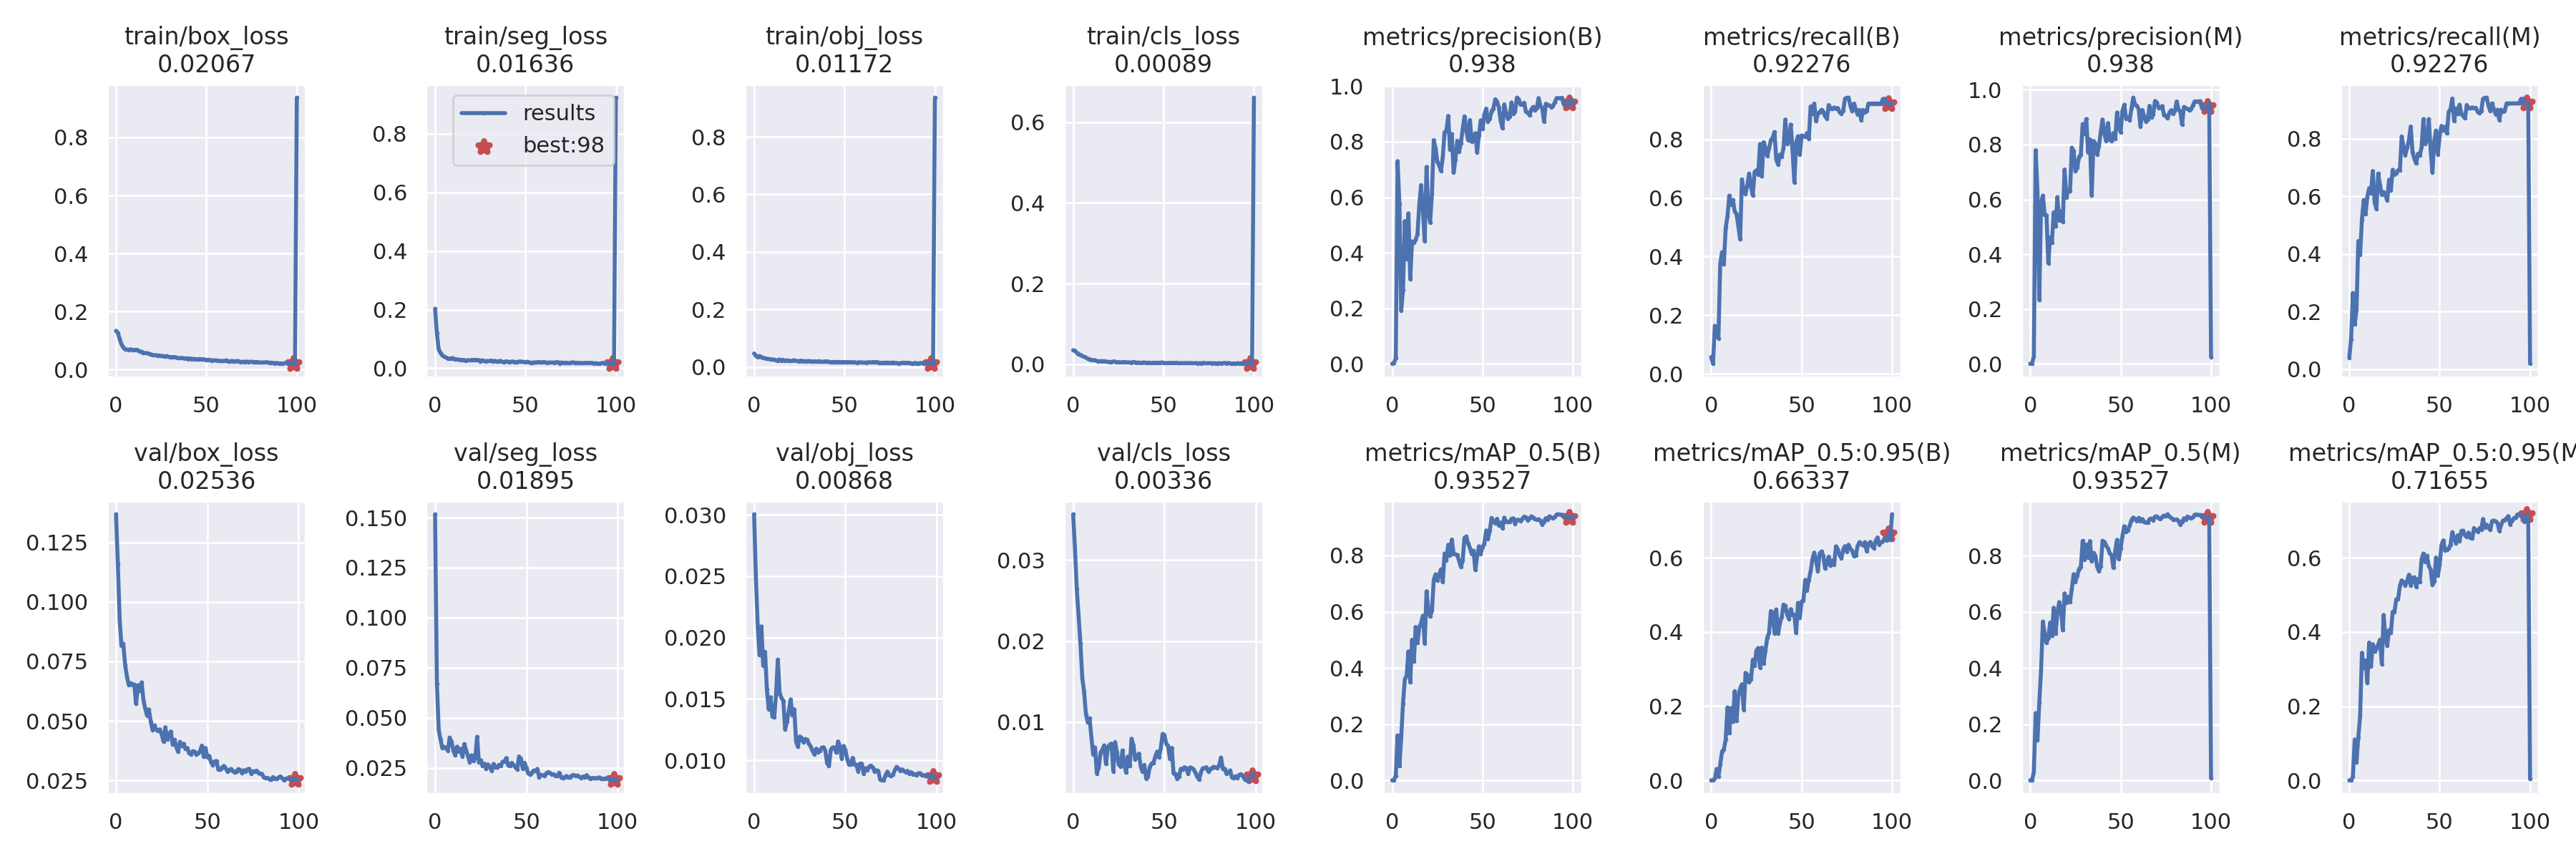

In [ ]:
# let's visualize the training results
Image(filename=f'{HOME}/yolov5/runs/train-seg/custom-dataset/results.png', width=600)

Let's analyse the following:
1. box_loss: At the end of the training, The **train loss** is relatively higher than the **validation loss**. However, the significance of such difference depends mainly on the performance objectives.
2. obj_loss: At the end of the training, the **validation loss** is smaller than the **train loss**. 
3. the cls losses are almost equivalent for both datasets.

The model is definitely not underfitting the problem in hand. As the current dataset is quite small, More data is likely to help reduce possible overfitting.

In [ ]:
# time to see how the model works on the test part of the dataset
%cd '{HOME}/yolov5'
!python segment/val.py --weights runs/train-seg/custom-dataset/weights/best.pt --img 640 --conf 0.7 --data {dataset.location}/data.yaml

/content/yolov5
segment/val: data=/content/yolov5/innopolis-detector-segmentation-3/data.yaml, weights=['runs/train-seg/custom-dataset/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.7, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val-seg, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.7 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-155-g8ecc727 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 165 layers, 1881103 parameters, 0 gradients, 6.7 GFLOPs
val: Scanning /content/yolov5/innopolis-detector-segmentation-3/valid/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100% 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 1/1 [00:02<00:00,  2.0

Metrics Evaluation:
1. The model performs relatively well on the test dataset.
2. The remarks derived from the confusion matrix are further supported by the model's performance on class **PERSON**: relatively low precision 0.561 mAP.
3. The model seems to have higher success with the robot class: 0.966 recall and 0.85
4. The final MAP is 0.706 which is relatively high
5. Inference time: 8.7ms per image
6. A size of: 28.5 megebytes

# MASK-RCNN

## Installing dependencies

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'detectron2'...
remote: Enumerating objects: 15012, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 15012 (delta 14), reused 26 (delta 8), pack-reused 14975
Receiving objects: 100% (15012/15012), 6.10 MiB | 17.64 MiB/s, done.
Resolving deltas: 100% (10877/10877), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# getting the datasetp
! curl -L "https://app.roboflow.com/ds/Mr2kAvgPaG?key=NMmsE9r923" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   905  100   905    0     0   1633      0 --:--:-- --:--:-- --:--:--  1633
100 28.8M  100 28.8M    0     0  9350k      0  0:00:03  0:00:03 --:--:-- 12.4M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/IMG_20230301_175636_259_jpg.rf.5eb7eb31b3fe7b2112ada4ed150b1193.jpg  
 extracting: test/IMG_20230302_103815_317_jpg.rf.5efd843115339add8d8d2084d009f8ca.jpg  
 extracting: test/IMG_20230302_104500_418_jpg.rf.983c11c87c4702670e44cc02b9fbae13.jpg  
 extracting: test/IMG_20230302_180921_292_jpg.rf.8426a49ac4f15be7ba7d3bb7af0cd3e0.jpg  
 extracting: test/IMG_20230302_181703_530_jpg.rf.19a200614797ab1c48b132b9266a159f.jpg  
 extracting: test/_annotations.coco.json  
   creating: train/
 extracting: train/IMG_20230228_151822_464_jpg.rf.124d96b610827

In [ ]:
# registering directly as it is in COCO format
from detectron2.data.datasets import register_coco_instances
register_coco_instances("innopolis_detector_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("innopolis_detector_valid", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("innopolis_detector_test", {}, "/content/test/_annotations.coco.json", "/content/test")


In [ ]:
from detectron2.engine import DefaultTrainer

ARCHITECTURE = "mask_rcnn_R_50_FPN_3x"
MODEL = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = ("innopolis_detector_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 400    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/29 09:41:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 229MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/29 09:41:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/29 09:42:12 d2.utils.events]:  eta: 0:02:03  iter: 19  total_loss: 2.813  loss_cls: 1.186  loss_box_reg: 0.9019  loss_mask: 0.6907  loss_rpn_cls: 0.04501  loss_rpn_loc: 0.01632    time: 0.3188  last_time: 0.3229  data_time: 0.0193  last_data_time: 0.0088   lr: 4.8453e-05  max_mem: 1769M
[04/29 09:42:24 d2.utils.events]:  eta: 0:01:52  iter: 39  total_loss: 2.42  loss_cls: 0.8329  loss_box_reg: 0.9554  loss_mask: 0.668  loss_rpn_cls: 0.02108  loss_rpn_loc: 0.01151    time: 0.3791  last_time: 0.3560  data_time: 0.0136  last_data_time: 0.0199   lr: 9.8403e-05  max_mem: 1769M
[04/29 09:42:30 d2.utils.events]:  eta: 0:01:43  iter: 59  total_loss: 2.144  loss_cls: 0.6128  loss_box_reg: 0.9231  loss_mask: 0.5985  loss_rpn_cls: 0.01962  loss_rpn_loc: 0.01099    time: 0.3539  last_time: 0.2535  data_time: 0.0117  last_data_time: 0.0140   lr: 0.00014835  max_mem: 1769M
[04/29 09:42:36 d2.utils.events]:  eta: 0:01:36  iter: 79  total_loss: 2.029  loss_cls: 0.5081  loss_box_reg: 0.8831  loss_m

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/29 09:44:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [ ]:
# let's evaluate the model on the test dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("innopolis_detector_test", cfg, False, output_dir="output")
val_loader = build_detection_test_loader(cfg, "innopolis_detector_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/29 09:44:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[04/29 09:44:23 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [04/29 09:44:23 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/29 09:44:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 09:44:23 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/test/_annotations.coco.json
[04/29 09:44:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/29 09:44:23 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/29 09:44:23 d2.data.common]: Serializing 5 ele

OrderedDict([('bbox',
              {'AP': 62.14933993399341,
               'AP50': 87.45874587458748,
               'AP75': 73.51485148514851,
               'APs': nan,
               'APm': 56.60066006600659,
               'APl': 70.77227722772277,
               'AP-robot-person': nan,
               'AP-person': 67.36798679867987,
               'AP-robot': 56.930693069306926}),
             ('segm',
              {'AP': 67.37128712871288,
               'AP50': 87.45874587458748,
               'AP75': 87.45874587458748,
               'APs': nan,
               'APm': 48.25082508250824,
               'APl': 84.04620462046205,
               'AP-robot-person': nan,
               'AP-person': 69.96699669966996,
               'AP-robot': 64.77557755775578})])

WARNING [04/29 09:44:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 09:44:24 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/valid/_annotations.coco.json
{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[390.0137, 273.7001, 565.6603, 517.0010],
        [345.5557, 204.8036, 433.6910, 305.2898],
        [463.1568, 133.5229, 511.2788, 156.4023]], device='cuda:0')), scores: tensor([0.9904, 0.9869, 0.8087], device='cuda:0'), pred_classes: tensor([2, 2, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, F

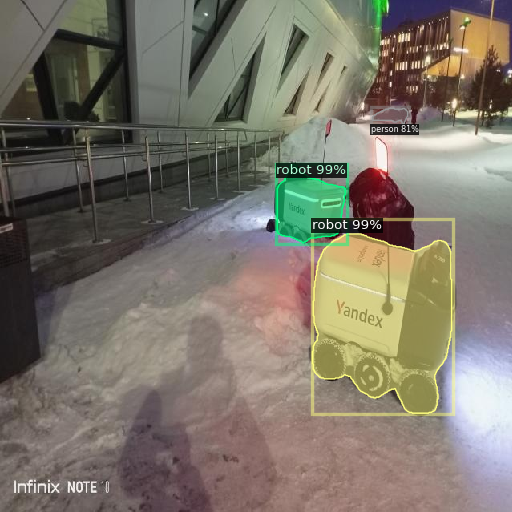

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 45.0979, 186.0843, 134.3555, 337.9134],
        [260.0858,  87.0098, 306.2680, 189.5796]], device='cuda:0')), scores: tensor([0.9863, 0.9458], device='cuda:0'), pred_classes: tensor([2, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, Fals

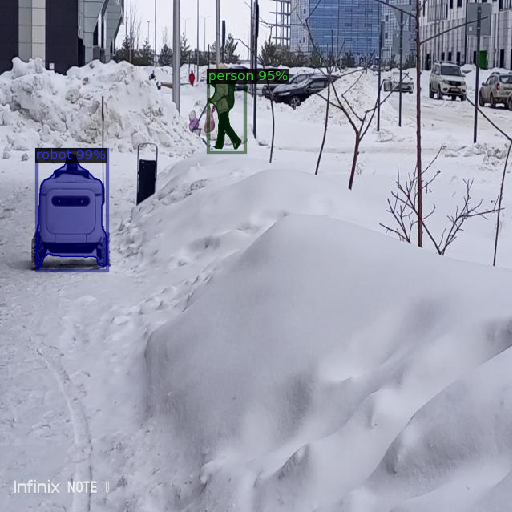

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[304.5193, 348.8468, 396.1297, 446.3875]], device='cuda:0')), scores: tensor([0.9702], device='cuda:0'), pred_classes: tensor([2], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


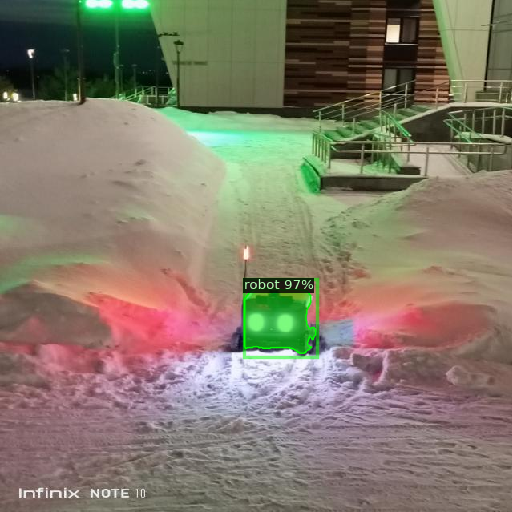

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[151.1505, 128.8240, 231.4087, 437.1689]], device='cuda:0')), scores: tensor([0.9651], device='cuda:0'), pred_classes: tensor([1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


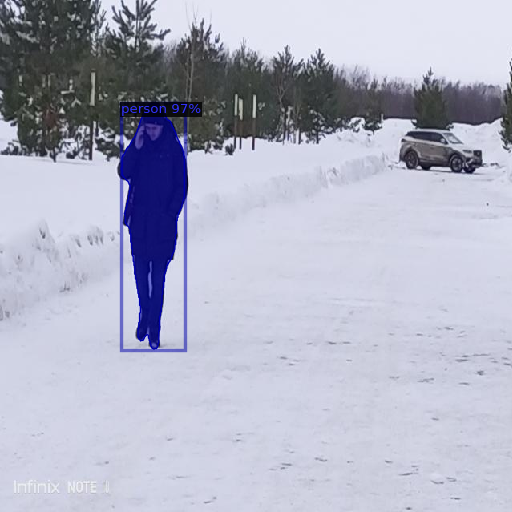

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[448.4440, 335.2766, 567.4550, 489.5963]], device='cuda:0')), scores: tensor([0.9908], device='cuda:0'), pred_classes: tensor([2], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


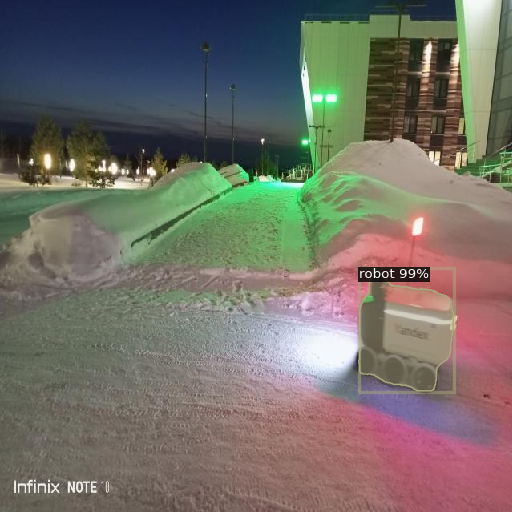

In [ ]:
metadata = MetadataCatalog.get('innopolis_detector_train')
dataset_valid = DatasetCatalog.get('innopolis_detector_valid')
count = 0
for d in dataset_valid:
    count += 1
    img = cv2.imread(d['file_name'])
    outputs = predictor(img)
    print(outputs)
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata, 
        scale=0.8
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    if count >= 5: break 


The faster RCNN performs relatively well on the problem.
* MAP: 0.481 
* Inference time: 0.087837s
* Size: 3.4 Gigabytes 

# Models Comparison
YOLOV5 (the nano model) VS Masked RCNN:
1. Mean Average Precision: 0.47 VS 0.698
2. Inference time: 6.6 ms VS 87 ms
3. Memory Requirements: 28.5 MB VS 3.4 GB

It seems that the yolov5 nano model outperforms Mask RCNN of every single metric: performance, inference and even memory. The models performances are quite likely to be improved with a larger dataset and more augmentation techniques.